# Region convolutional neural network (R-CNN) object detetion with Keras, TensorFlow and Deep Learning
(Under develepment)

***This juppyter notebook is not organized and are just unorganized notes taked during my study.***

Four steps [reference](https://towardsdatascience.com/step-by-step-r-cnn-implementation-from-scratch-in-python-e97101ccde55): 
1. Pass the image through selective search and generate region proposal.
2. Calculate IOU (intersection over union) on proposed region with groud truth data and add label to the proposed regions
3. Do transfer learning using the proposed regions with the labels.
4. Pass the test image to selective search and then passe the first 2000 proposed regions from the trained model and predict the class of those regions.

Six steps [reference](https://www.pyimagesearch.com/2020/07/13/r-cnn-object-detection-with-keras-tensorflow-and-deep-learning/):
1. Build object detection dataset with Selective Search
2. Fine-tune classification model on dataset
3. During inference, run Selective Search on input image
4. Make predictions on each proposal using fine-tuned model
5. Apply NMS (non-maxima suprssion)
6. Return final object detection results

## Data set

The dataset used is the [German Traffic Signs Dataset](https://medium.com/datadriveninvestor/traffic-sign-recognition-using-convolutional-neural-networks-cnn-f7dc5d9d53ba) containing images of shape (32x32x3)



*   The training set has 34799 images
*   The validation set has 4410 images
*   The test set has 12630 images
*   The dataset has **43 unique classes**


**Structure:**
*  One directory per class
*  Each directory container CSV file wit annotations name: GT\<class id \>.csv and the training images
*  training images grouped by tracks (each track has 30 images of one single traffic sign)


**Annotation structure:**
+  CSV with 8 columns
    +  **Filename**
    + **Width**
    + **Height**
    + **x of top left corner**
    + **y of top left corner**
    + **x bottom right corner**
    + **y of bottom right corner**
    + **class id**


We are going to use the same dataset with the [training](https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip) and [test](https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip) data in a different format.

You can get the train data [here](https://drive.google.com/file/d/1AZeKw90Cb6GgamTBO3mvDdz6PjBwqCCt/view) with the label values [here](https://www.murtazahassan.com/wp-content/uploads/2020/08/labels.zip)


### **Region of Interest (ROI)**
The region of interest (ROI) are defined in the file gt.txt

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os

### Intersection over Union
[Reference](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/)

Intersection over Union (IOU) is an **evaluation metric** used to measure the accuracy of an object detetor on a particular dataset. In order to apply IOU to evaluate an (arbitrary) object detector we need:
1. The groundh-trhith bounding boxes (i.e., the hand labeled bounding boxes from the testing set that specify where in the image our object is).
2. The predicted bounding boxes from our model

The IOU can be determined via:
$$ IOU = \frac{Area \; of \; Overlap}{Area \; of \; Union}$$

An IOU score > 0.5 is normally considered a "good" prediction.

In [ ]:
# Function to calculate IOU (Intersection Over Union)

def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']    
    
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])    
    
    if x_right < x_left or y_bottom < y_top:
        return 0.0    
    
    intersection_area = (x_right - x_left) * (y_bottom - y_top)    
    
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])    
    
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

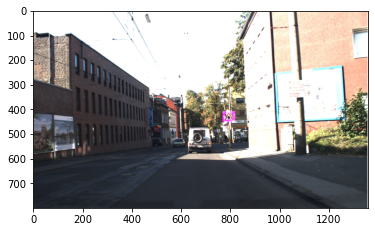

In [41]:
folder = !ls "/mnt/hgfs/OneDrive_UP/FCUP/MDS/1º ano/1º semestre/5 - Visão Computacional/Trabalho/FullIJCNN2013/"*.ppm

import cv2
import matplotlib.pyplot as plt
import numpy as np 

image = cv2.imread(folder[0]) # load the image (read in BGR)
line_image = np.zeros_like(image)
cv2.line(line_image, (774,411), (774, 446), (255,0,255), thickness=10)
cv2.line(line_image, (774,411), (815, 411), (255,0,255), thickness=10)
cv2.line(line_image, (774,446), (815, 446), (255,0,255), thickness=10)
cv2.line(line_image, (815,411), (815, 446), (255,0,255), thickness=10)
#plt.imshow(image[...,(2,1,0)])
combo_image = cv2.addWeighted(image[...,(2,1,0)], 1, line_image, 1, 1)
plt.imshow(combo_image)
#plt.imshow(line_image)
#plt.show()
#img = cv2.imread('messi5.jpg',0)

#ImgNo#.ppm;#leftCol#;##topRow#;#rightCol#;#bottomRow#;#ClassID#
#774;411;815;446

In [173]:
data_folder = "/mnt/hgfs/OneDrive_UP/FCUP/MDS/1º ano/1º semestre/5 - Visão Computacional/Trabalho/FullIJCNN2013/"
figures_list = !ls "/mnt/hgfs/OneDrive_UP/FCUP/MDS/1º ano/1º semestre/5 - Visão Computacional/Trabalho/FullIJCNN2013/"*.ppm


In [158]:
# Region of Interest
# (bounding boxes)

gt = open(data_folder +"gt.txt", "r")
content = gt.read()#line()
#print(content)
gt.close()
content = content.split()

for k in range(len(content)):
    content[k] = content[k].split(';')
    content[k][0] = content[k][0].split('.')[0]
    for k2 in range(len(content[k])):
        content[k][k2] = int(content[k][k2])


**Image pyramids**: Localize objects at different scales/sizes.
**Sliding windows**: Detect exactly where in the iage a given object is.
**Non-maxima supression**: Collapse weak, overlaping bounding boxes.

Flow of the algorithm:
1. Input an image
2. Construct an image pyramid
3. For each scale of the image pyramid, run a sliding window:
    * 3a - For each stop of the sliding window, extract the ROI
    * 3b - Take the ROI and pass it through our CNN originally trained for image classification
    * 3c - Examine the probability of the top class label of the CNN, and if meets a minimum confidence, record (1) the class label and (2) the location of the sliding window
4. pply class-wise non-maxima supression to the bounding boxes
5. Return results to calling function



### Implementing our image pyramid and sliding window utility functions
[Reference](https://www.pyimagesearch.com/2020/06/22/turning-any-cnn-image-classifier-into-an-object-detector-with-keras-tensorflow-and-opencv/)

image_pyramid - Assists in generating copies of our image at different scales so that we can find objects of different sizes ([Reference](https://www.pyimagesearch.com/2015/03/23/sliding-windows-for-object-detection-with-python-and-opencv/))

sliding_window - Helps us find where in the image an object is by sliding our classification window from left-to-righ (column-wise) and top-to-bottom (row-wise) ([Reference](https://www.pyimagesearch.com/2015/03/16/image-pyramids-with-python-and-opencv/))

In [169]:
pip install --upgrade imutils
# https://github.com/jrosebr1/imutils

  Created wheel for imutils: filename=imutils-0.5.3-py3-none-any.whl size=25853 sha256=35837810b40369c4f9352580217de17110aa640354622886f43439bb0200bccf
  Stored in directory: /home/erst/.cache/pip/wheels/c8/d6/0f/b0c3892b70c59f0d202f8619a449f7d14cb839a0af2f943869
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [20]:

import imutils

def sliding_window(image, step, ws):
    '''
    image - input image
    step - step size of the sliding (it is common to use steps of 4 to 8 pixels)
    ws - window size. Defines the width and height (in pixels) of the window we are going to extract from the image
    '''
    # slide a window across the image
    for y in range(0,image.shape[0] - ws[1], step): # loop over rows
        for x in range(0, image.shape[1] - ws[0], step): # loop over columns
            # yield the current window
            yield (x, y, image[y:y + ws[1], x:x + ws[0]])


            
import cv2
import time

figures_list = !ls "/mnt/hgfs/OneDrive_UP/FCUP/MDS/1º ano/1º semestre/5 - Visão Computacional/Trabalho/FullIJCNN2013/"*.ppm
image = cv2.imread(figures_list[0])
(winW, winH) = (128,128*4)

# loop over the sliding window for each layer of the pyramid
for (x, y, window) in sliding_window(image, step=32, ws =(winW, winH)):
    # if the window does not meet our desired window size, ignore it
    if window.shape[0] != winH or window.shape[1] != winW:
        continue
    
    clone = image.copy()
    cv2.rectangle(clone, (x,y), (x + winW, y + winH), (0, 255, 0), 2)
    cv2.imshow("Window",clone)
    cv2.waitKey(1)
    time.sleep(0.025)

In [21]:
import numpy as np
b = np.array([[0,0,0],[1,2,3]])


543